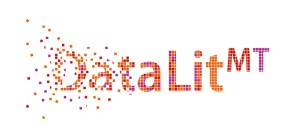

# Data Planning and Data Collection – Advanced Level
**How to select, download, prepare and process data for training NMT models**

# Introduction

This Colab Notebook is concerned with the *Data Planning and Data Collection (& Production)* dimensions of the [DataLit<sup>MT</sup> Competence Matrix](https://itmk.github.io/The-DataLitMT-Project/matrix/). The notebook guides you step-by-step through gathering, preparing and processing data in order to train a neural machine translation (NMT) model, using, for example the [OpenNMT-py toolkit](https://opennmt.net/OpenNMT-py/). These steps are the central preparatory steps of an MT training pipeline, which is covered under *Technical MT Literacy* in the [Professional Machine Translation Literacy Framework](https://itmk.github.io/The-DataLitMT-Project/framework/#professional-mt-literacy). The code sections of this notebook are based on [Yasmin Moslem's repository for MT data preparation](https://github.com/ymoslem/MT-Preparation). You might also be interested in [this TAUS article on data cleaning for natural language processing](https://www.taus.net/resources/blog/ten-step-guide-to-data-cleaning), which highlights the various steps of a data cleaning pipeline. The first five steps discussed in this article are also covered in this notebook.

**General Information**

NMT models are trained on large datasets in the form of bilingual text corpora, which are aligned at sentence-level. NMT models are very sensitive to defects (also called 'noise') in their training data, as described, for example, in [Khayrallah/Koehn (2018)](https://aclanthology.org/W18-2709/). Therefore, thoroughly preparing the training datasets (cleaning, filtering, aligning, tokenizing, etc.) is paramount for creating high-quality NMT models.

**Note:** To avoid losing your data produced throughout this notebook, do **not** close this window until you have completed all steps and downloaded the datasets locally or saved them to your Google Drive! This step is illustrated at the end of this notebook.

A walk-through of this notebook and more detailed information on gathering and preparing data and the detailed steps performed in the code cells is provided in the accompanying tutorial video.

---
**Steps to take**

As outlined in our DataLit<sup>MT</sup> Competence Matrix, a number of steps have to be taken to acquire data for training an NMT model. A **data requirement analysis** will show you which bilingual (also called parallel) data will be needed for training an NMT model that suits your individual requirements (domain, language combination, etc.). For more information on how to create custom machine translation models, see the chapter by [Ramírez-Sánchez (2022)](https://zenodo.org/record/6760022/files/342-Kenny-2022-9.pdf). Based on your data requirement analysis, you can then develop a **data strategy**, which will outline the steps required to obtain the data. Taking into account relevant aspects of **data curation and protection**, you can then identify and evaluate suitable sources for downloading bilingual datasets. For example, one source of publicly available parallel datasets, which can be used for training NMT models, is the [OPUS corpus collection](https://opus.nlpl.eu). Most datasets in the OPUS collection are available for non-commercial (research) use and can be searched by simply selecting a source and a target language. Once you have found a suitable dataset, you can **verify** this data by checking the type of dataset (web-crawled etc.) and clicking on *sample* to check the quality of the data. For MT, [moses](http://www2.statmt.org/moses/index.php?n=Main.HomePage) is used as the preferred download format, as the sentences are already aligned (meaning that every line in the source file refers to that same line in the target file, i.e., these lines are translations of each other). You can then **acquire** the data by clicking on the *moses* field or by running the cell below (when you right-click on the *moses* field of the dataset you selected on the OPUS website, you can copy the link to download the dataset. This is also shown in the accompanying tutorial video).

For our current MT project scenario, we choose to work with the English-German parallel dataset *TED2020*, where we chose English as the source and German as the target language. When running the cell below, a .zip file will be downloaded and the two files we're interested in are those that end on the language codes: `.en` and `.de`. The data we prepare and save in this notebook can then be used to train an NMT model from scratch using our [NMT Training notebook](https://colab.research.google.com/drive/1f3V7CshfVvrA5S6XtLAvl-beqBPN3qar?usp=sharing).

Note: TED2020 is a comparatively small dataset for NMT training, containing 'only' 300,000 parallel sentences (more information on this dataset can be found [here](https://opus.nlpl.eu/TED2020.php)). This is sufficient to train a demo NMT model and to go through all steps required. Note, however, that datasets for training more efficient and high-performing NMT models, usually contain millions of sentences.

Run the following cell to download the dataset from the OPUS collection.

In [1]:
!wget https://object.pouta.csc.fi/OPUS-TED2020/v1/moses/de-en.txt.zip
!unzip de-en.txt.zip

--2023-02-27 11:35:35--  https://object.pouta.csc.fi/OPUS-TED2020/v1/moses/de-en.txt.zip
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18, 86.50.254.19
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21857900 (21M) [application/zip]
Saving to: ‘de-en.txt.zip’

de-en.txt.zip       100%[===================>]  20.84M  10.9MB/s    in 1.9s    

2023-02-27 11:35:38 (10.9 MB/s) - ‘de-en.txt.zip’ saved [21857900/21857900]

Archive:  de-en.txt.zip
  inflating: README                  
  inflating: LICENSE                 
  inflating: TED2020.de-en.de        
  inflating: TED2020.de-en.en        
  inflating: TED2020.de-en.xml       


This should give you the two monolingual files:

*   `TED2020.de-en.en`
*   `TED2020.de-en.de`

Note: we will not be working with the third file, i.e., the xml file.

Each file has a sentence/segment per line that is a matching (aligned) translation of the same line in the other file (this is called [parallel text format](https://google.github.io/seq2seq/nmt/)).

Note: If you wish to download a different dataset, just change the URL in the code cell above (make sure, that the data is still in *moses* format).

# Data Preparation

Now we move on to filtering, **preparing and processing** this dataset. At the end of the notebook, we will show you how to download the resulting datasets to a local drive or how to save them to your Google Drive. After making sure that the data intended to train an NMT model is a bilingual dataset aligned at sentence-level, we can take different steps to clean this MT training data. These steps are outlined below.

**Installing Necessary Library-Requirements**

First, we'll install a range of necessary python libraries which are required for our data preparation. To do so, simply run the cells below.

In [ ]:
!pip install numpy
!pip install pandas
!pip install sacremoses
!pip install sentencepiece

In [3]:
import pandas as pd
import numpy as np
import re
import csv
import sys

**Defining Datasets and Languages**

Now, we'll define our source file and language (source dataset, English) as well as our target file and language (target dataset, German) based on the *TED2020* dataset we downloaded in the previous step. Simply run the cell below. From now on, we'll work with the variables `source_file`, `target_file`, `source_lang` and `target_lang`.

In [4]:
source_file = "TED2020.de-en.en"
target_file = "TED2020.de-en.de"
source_lang = "en"
target_lang = "de"

Note: If you have downloaded a different dataset, simply change the names and languages (marked in red) in the strings above to match your data.

**Filtering & Cleaning Datasets for MT Training**

Now we move on to actually filtering and cleaning the datasets, as required for MT training purposes. This step will take the two source and target files and delete rows that contain empty cells, delete duplicates, source-copied rows and source/target sentences that are too long, remove HTML code, list how many rows will remain in true-cased form, delete rows with empty cells, shuffle rows and finally save source and target files (= filtered dataset). You can find more information on these data preparation steps in section 3 of [Bui et al. (2020)](https://aclanthology.org/2020.eamt-1.35). The final files should be adequately filtered and cleaned for NMT training purposes. 

The separate steps of cleaning and filtereing the source and target files are shown below. You do **not** need to change any parts of the code, simply run the cells and check out the different data preparation stages.

For a more compact version of preparing your data, check out our [basic-level notebook](https://colab.research.google.com/drive/17aCfPF0Zw80gW0FYg_iRo16YVSMAaNKG?usp=sharing).

1. Run the cell below to create a [dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

In [5]:
# display(df) works only if you are in IPython/Jupyter Notebooks or enable:
#from IPython.display import display

df_source = pd.read_csv(source_file, names=['Source'], sep="\n", quoting=csv.QUOTE_NONE, skip_blank_lines=False, on_bad_lines="skip")
df_target = pd.read_csv(target_file, names=['Target'], sep="\n", quoting=csv.QUOTE_NONE, skip_blank_lines=False, on_bad_lines="skip")
df = pd.concat([df_source, df_target], axis=1)  # Join the two dataframes along columns

print("Dataframe shape (rows, columns):", df.shape)

Dataframe shape (rows, columns): (296354, 2)


2. Run the cell below to delete rows with empty cells.

In [6]:
df = df.dropna()

print("Rows with Empty Cells Deleted --> Rows:", df.shape[0])

Rows with Empty Cells Deleted --> Rows: 293645


3. Run the cell below to delete duplicates.

In [7]:
df = df.drop_duplicates()

print("Duplicates Deleted --> Rows:", df.shape[0])

Duplicates Deleted --> Rows: 289373


4. Run the cell below to delete source-copied rows.

In [ ]:
df["Source-Copied"] = df['Source'] == df['Target']
df = df.set_index(['Source-Copied'])

try: # To avoid (KeyError: '[True] not found in axis') if there are no source-copied cells
    df = df.drop([True]) # Boolean, not string, do not add quotes
except:
    pass
    
df = df.reset_index()
df = df.drop(['Source-Copied'], axis = 1)
    
print("Source-Copied Rows Deleted --> Rows:", df.shape[0])

5. Run the cell below to delete source/target sentences that are too long.

In [9]:
df["Too-Long"] = ((df['Source'].str.count(' ')+1) > (df['Target'].str.count(' ')+1) * 2) |  \
                 ((df['Target'].str.count(' ')+1) > (df['Source'].str.count(' ')+1) * 2) |  \
                 ((df['Source'].str.count(' ')+1) > 200) |  \
                 ((df['Target'].str.count(' ')+1) > 200)
                
df = df.set_index(['Too-Long'])

try: # To avoid (KeyError: '[True] not found in axis') if there are no too-long cells
    df = df.drop([True]) # Boolean, not string, do not add quotes
except:
    pass

df = df.reset_index()
df = df.drop(['Too-Long'], axis = 1)

print("Too Long Source/Target Deleted --> Rows:", df.shape[0])

Too Long Source/Target Deleted --> Rows: 286843


6. Run the cell below to remove HTML code.

In [10]:
# Use str() to avoid (TypeError: expected string or bytes-like object)
# Note: removing tags should be before removing empty cells because some cells might have only tags and become empty.

df = df.replace(r'<.*?>|&lt;.*?&gt;|&?(amp|nbsp|quot);|{}', ' ', regex=True)
df = df.replace(r'  ', ' ', regex=True)  # replace double-spaces with one space

print("HTML Removed --> Rows:", df.shape[0])

HTML Removed --> Rows: 286843


7. Run the cell below to list how many rows will remain in true-cased form (truecasing is an NLP problem of finding the proper capitalisation of words within a text where such information is unavailable; for more information, see [this article](https://towardsdatascience.com/truecasing-in-natural-language-processing-12c4df086c21)).

In [11]:
lower=False
if lower == True:
  df['Source'] = df['Source'].str.lower()
  df['Target'] = df['Target'].str.lower()

  print("Rows are now lower-cased --> Rows:", df.shape[0])
else:
  print("Rows will remain in true-cased --> Rows:", df.shape[0])

Rows will remain in true-cased --> Rows: 286843


8. Run the cell below to replace empty cells with [`NaN`](https://pandas.pydata.org/docs/user_guide/missing_data.html) and delete `NaN` (either already there, or generated from the previous steps).

In [12]:
df = df.replace(r'^\s*$', np.nan, regex=True)

df = df.dropna()

print("Rows with Empty Cells (Nan) Deleted --> Rows:", df.shape[0])

Rows with Empty Cells (Nan) Deleted --> Rows: 286843


9. Run the cell below to shuffle rows.

In [13]:
df = df.sample(frac=1).reset_index(drop=True)

print("Rows Shuffled --> Rows:", df.shape[0])

Rows Shuffled --> Rows: 286843


**Preparing to save the data**
10. Run the cell below to write the dataframe to two filtered and cleaned source and target files.

In [14]:
source_filtered = source_file+'-filtered.'+source_lang
target_filtered = target_file+'-filtered.'+target_lang

11. Run the cell below to save the filtered and cleaned source and target files.

In [15]:
df_source = df["Source"]
df_target = df["Target"]

df_source.to_csv(source_filtered, header=False, index=False, quoting=csv.QUOTE_NONE, sep="\n")
print("Filtered Source Saved:", source_filtered)

df_target.to_csv(target_filtered, header=False, index=False, quoting=csv.QUOTE_NONE, sep="\n")
print("Filtered Target Saved:", target_filtered)

Filtered Source Saved: TED2020.de-en.en-filtered.en
Filtered Target Saved: TED2020.de-en.de-filtered.de


As a final output, you should now have the two filtered and cleaned source and target files:

*  source data: `TED2020.de-en.en-filtered.en`
*  target data: `TED2020.de-en.de-filtered.de`



**Checking the Dataset** 

It is always good practice to check your dataset in between steps to make sure that everything has worked well. For example, you could check that sentences are properly aligned. Run the cell below to print the first and last two lines of the filtered and cleaned source and target files.

In [16]:
print("First 2 Lines:")
!head -n 2 'TED2020.de-en.en-filtered.en' && echo "----" && head -n 2 'TED2020.de-en.de-filtered.de'
print()
print("Last 2 Lines:")
!tail -n 2 'TED2020.de-en.en-filtered.en' && echo "-----" && tail -n 2 'TED2020.de-en.de-filtered.de'

First 2 Lines:
He said that he had been in the Gulf a little while ago; like about a week ago, and a guy who had been a recreational fishing guide took him out to show him what's going on. 
On the other side of the country, I went to class and wrote a poem in the margins of my notebook. 
----
Er erzaehlte mir, dass er vor kurzem am Golf gewesen sei, -- vor etwa einer Woche -- und ein Mann, der als Tourguide fuer Freizeitangler gearbeitet hatte, nahm ihn mit, um ihm zu zeigen, was los war. 
Auf der anderen Seite des Landes ging ich zur Schule und schrieb ein Gedicht an meinen Heftrand. 

Last 2 Lines:
It's just love. That's all it is. 
Now, why are algorithms even important? 
-----
Es ist Liebe. Das ist alles. 
Warum sind Algorithmen überhaupt wichtig? 


# (Subword) Tokenizing with SentencePiece

For the next step of our data preparation pipeline, we will tokenize the previously filtered datasets. This is a necessary step for MT training. Unlike humans, a computer does not read text in the form of individual words and sentences, but rather as a continuous string of characters (blank spaces included). Therefore, text (vocabulary) used to train MT models (and other Natural Language Processing or NLP models) must be tokenized so that the models know where the boundaries between individual words (and sentences) are.

A special form of tokenization is subwording, where words are split into smaller units (so-called subwords) from which complete words can be assembled. The subword tokenization method is described in more detail in [Sennrich et al. (2016)](https://aclanthology.org/P16-1162/). NMT models are usually trained with such subwords instead of whole words in order to reduce the size of the NMT model’s vocabulary (the larger the vocabulary, the higher the data processing requirements will be). For example, the four words *low*, *lowest*, *high* and *highest* can be represented by the three subwords *low*, *high* and *est*, which would reduce the required vocabulary size of the NMT model by 1. During translation, when the MT model comes across a new word/token that resembles a word/token that is also present in its training vocabulary (or can be assembled from the subwords in this vocabulary), the MT model will be able to translate this word/token. Otherwise, it would produce an “unk” (= “unknown”) token as output. If you would like to know more about (subword) tokenization for training NLP models, have a look at [this article](https://blog.floydhub.com/tokenization-nlp/).

A preferred toolkit for subword tokenization is [SentencePiece](https://github.com/google/sentencepiece). To apply SentencePiece, a subwording model must first be trained on the source and target files of the dataset. This model can then be applied to these files in order to subword them. These subworded source and target files are then used in the MT training process. When the trained model is used for translating, it will produce a subworded translation. Using the same SentencePiece model, this subworded translation must then be “desubworded” or “decoded” back into fluent text. Note that in systems such as DeepL or Google Translate, these subwording and desubwording steps are performed "backstage" so that we as users are not aware of them.

Follow the steps below (again, do not change any code, simply run the cells) to train a SentencePiece model for subword tokenization based on the two previously filtered files: `TED2020.de-en.en-filtered.en` and `TED2020.de-en.de-filtered.de`.

First, run the cell below to import further requirements for SentencePiece.

In [17]:
import sentencepiece as spm

Run the cell below to create paths for the filtered and cleaned source and target files.

In [18]:
path = ""    # change the path if needed

train_source_file_tok = path + source_filtered
train_target_file_tok = path + target_filtered

Now we'll train SentencePiece models from the source and target files and create `source/target.model` and `source/target.vocab`. `source/target.vocab` is just a reference, not used in the segmentation.

**Training the source subword model**

Run the cell below to train a SentencePiece subwording model on the filtered source file.


In [19]:
# Source subword model

source_train_value = '--input='+train_source_file_tok+' --model_prefix=source --vocab_size=50000 --hard_vocab_limit=false --split_digits=true'
spm.SentencePieceTrainer.train(source_train_value)
print("Done, training a SentencepPiece model for the Source finished successfully!")

Done, training a SentencepPiece model for the Source finished successfully!


**Training the target subword model**

Run the cell below to train a SentencePiece subwording model on the filtered target file.

In [20]:
# Target subword model

target_train_value = '--input='+train_target_file_tok+' --model_prefix=target --vocab_size=50000 --hard_vocab_limit=false --split_digits=true'
spm.SentencePieceTrainer.train(target_train_value)
print("Done, training a SentencepPiece model for the Target finished successfully!")

Done, training a SentencepPiece model for the Target finished successfully!


Two separate SentencePiece subwording models have now been trained: `source.model` and `target.model`. At the end of this notebook, we will also save the subworded source and target model as these will be needed for future subwording and desubwording (the subwording and desubwording step is also required in the [NMT Training notebook](https://colab.research.google.com/drive/1f3V7CshfVvrA5S6XtLAvl-beqBPN3qar?usp=sharing)).

**Subwording the filtered source and target datasets**

By applying these source and target SentencePiece models, the previously filtered files can now be subworded. To do so, run the cells below.

In [21]:
source_model = 'source.model'
target_model = 'target.model'
source_subworded = source_filtered + ".subword"
target_subworded = target_filtered + ".subword"

print("Source Model:", source_model)
print("Target Model:", target_model)
print("Filtered Source Dataset:", source_filtered)
print("Filtered Target Dataset:", target_filtered)

Source Model: source.model
Target Model: target.model
Filtered Source Dataset: TED2020.de-en.en-filtered.en
Filtered Target Dataset: TED2020.de-en.de-filtered.de


In [22]:
sp = spm.SentencePieceProcessor()

**Subwording the source dataset**

Run the cell below to apply the source SentencePiece model on the filtered source file `TED2020.de-en.en-filtered.en`.

In [23]:
sp.load(source_model)

with open(source_filtered) as source, open(source_subworded, "w+") as source_subword:
    for line in source:
        line = line.strip()
        line = sp.encode_as_pieces(line)
        # line = ['<s>'] + line + ['</s>']    # add start & end tokens; optional
        line = " ".join([token for token in line])
        source_subword.write(line + "\n")

print("Done subwording the source file! Output:", source_subworded)

Done subwording the source file! Output: TED2020.de-en.en-filtered.en.subword


**Subwording the target dataset**

Run the cell below to apply the target SentencePiece model on the filtered target file `TED2020.de-en.de-filtered.de`.

In [24]:
sp.load(target_model)

with open(target_filtered) as target, open(target_subworded, "w+") as target_subword:
    for line in target:
        line = line.strip()
        line = sp.encode_as_pieces(line)
        # line = ['<s>'] + line + ['</s>']    # add start & end tokens; unrequired for OpenNMT
        line = " ".join([token for token in line])
        target_subword.write(line + "\n")

print("Done subwording the target file! Output:", target_subworded)

Done subwording the target file! Output: TED2020.de-en.de-filtered.de.subword


As an output, you should now have two subworded datasets:

*   source dataset: `TED2020.de-en.en-filtered.en.subword`
*   target dataset: `TED2020.de-en.de-filtered.de.subword`

Note: We will cover **desubwording** at the end of the [NMT Training notebook](https://colab.research.google.com/drive/1f3V7CshfVvrA5S6XtLAvl-beqBPN3qar?usp=sharing).

**Checking the Dataset** 

As before, you can check your dataset to make sure that they have been properly subworded. Run the cell below to print the first and last two lines of each filtered subworded file.

In [25]:
print("First 2 Lines:")
!head -n 2 'TED2020.de-en.en-filtered.en.subword' && echo "----" && head -n 2 'TED2020.de-en.de-filtered.de.subword'
print()
print("Last 2 Lines:")
!tail -n 2 'TED2020.de-en.en-filtered.en.subword' && echo "-----" && tail -n 2 'TED2020.de-en.de-filtered.de.subword'

First 2 Lines:
▁He ▁said ▁that ▁he ▁had ▁been ▁in ▁the ▁Gulf ▁a ▁little ▁while ▁ago ; ▁like ▁about ▁a ▁week ▁ago , ▁and ▁a ▁guy ▁who ▁had ▁been ▁a ▁recreation al ▁fishing ▁guide ▁took ▁him ▁out ▁to ▁show ▁him ▁what ' s ▁going ▁on .
▁On ▁the ▁other ▁side ▁of ▁the ▁country , ▁I ▁went ▁to ▁class ▁and ▁wrote ▁a ▁poem ▁in ▁the ▁margins ▁of ▁my ▁notebook .
----
▁Er ▁erzaehlt e ▁mir , ▁dass ▁er ▁vor ▁kurzem ▁am ▁Golf ▁gewesen ▁sei , ▁-- ▁vor ▁etwa ▁einer ▁Woche ▁-- ▁und ▁ein ▁Mann , ▁der ▁als ▁Tour guide ▁ fuer ▁Freizeit ang ler ▁gearbeitet ▁hatte , ▁nahm ▁ihn ▁mit , ▁um ▁ihm ▁zu ▁zeigen , ▁was ▁los ▁war .
▁Auf ▁der ▁anderen ▁Seite ▁des ▁Landes ▁ging ▁ich ▁zur ▁Schule ▁und ▁schrieb ▁ein ▁Gedicht ▁an ▁meinen ▁Heft rand .

Last 2 Lines:
▁It ' s ▁just ▁love . ▁That ' s ▁all ▁it ▁is .
▁Now , ▁why ▁are ▁algorithms ▁even ▁important ?
-----
▁Es ▁ist ▁Liebe . ▁Das ▁ist ▁alles .
▁Warum ▁sind ▁Algorithmen ▁überhaupt ▁wichtig ?


Note: The underscores indicate that there is a space before the respective tokens, meaning that, in a sentence, word tokens with an underscore preceding them can act as independent words. Word tokens without an underscore (not included in our example sentences above) could only act as suffixes to other word tokens. If you can see a question mark token at the beginning of a sentence, for example, you'll notice it is missing an underscore. This means that there is no space before this token and that it therefore always follows a preceding token without a space between the two (which is how we actually use a question mark in language). This becomes clearer when you compare a subworded and a desubworded translation output in our [NMT Training notebook](https://colab.research.google.com/drive/1f3V7CshfVvrA5S6XtLAvl-beqBPN3qar?usp=sharing).

# Splitting Datasets

Now that we have cleaned, filtered and subworded the source and target files in our dataset, we need to **split** this dataset for MT training purposes. 

To train an NMT model, three distinct sub-datasets (of both the source and the target files) are required:

1. **training dataset** – used to actually train the model,
2. **development dataset** – used to run regular validations during the training stage of the NMT model to help improve the model parameters,
3. **test dataset** – used after the model is fully trained to evaluate the model on data the model has not yet seen in the training stage (to provide a test translation).

The training dataset should be by far the largest of the three datasets and represent about 70-80% of the original dataset. Both the development and the test datasets can be of equal size of around 10-15% of the original dataset.

Note: Our total TED2020 dataset contains 300,000 segments (as described in the introduction), so for this MT project, we define the development and test sub-datasets to consist of 35,000 segments each (a little more than 10% each, as indicated in the cell below). This means that the training dataset will consist of around 216,000 segments (almost 80%, as indicated above). Run the cell below to simultaneously split both the source and the target files of the original dataset into three sub-datasets: a training, development and a test dataset.

1. Run the cell below to define the number of segments in the development (dev) and the test set.

In [26]:
segment_no_dev = 35000
segment_no_test = 35000

2. Run the cell below to define a dataframe, using the subworded source `TED2020.de-en.en-filtered.en.subword` and target `TED2020.de-en.de-filtered.de.subword` files.

In [27]:
df_source = pd.read_csv(source_subworded, names=['Source'], sep="\n", quoting=csv.QUOTE_NONE, error_bad_lines=False)
df_target = pd.read_csv(target_subworded, names=['Target'], sep="\n", quoting=csv.QUOTE_NONE, error_bad_lines=False)
df = pd.concat([df_source, df_target], axis=1)  # Join the two dataframes along columns
print("Dataframe shape:", df.shape)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


Dataframe shape: (286843, 2)


3. Run the cell below to delete rows with empty cells (both in the source and target).

In [28]:
df = df.dropna()

print("Empty Cells Deleted", "--> Rows:", df.shape[0])

Empty Cells Deleted --> Rows: 286843


4. Run the cell below to extract the development (dev) and test set from the main dataset.

In [29]:
# Extract Dev set
df_dev = df.sample(n = int(segment_no_dev))
df_train = df.drop(df_dev.index)

# Extract Test set
df_test = df_train.sample(n = int(segment_no_test))
df_train = df_train.drop(df_test.index)

5. Run the cell below to write the dataframe to two source and target files.

Note: The ending such as `-filtered.en.subword.train` can also be changed to just `.train` in the future to have shorter file names. We do **not** recommend to change the names here, as we refer to these data files *exactly* as they are named here in our [NMT Training notebook](https://colab.research.google.com/drive/1f3V7CshfVvrA5S6XtLAvl-beqBPN3qar?usp=sharing). So if you wish to train an NMT model from scratch using our tutorial, do not change the names of the files until you are fully confident to do so everywhere where necessary.

In [30]:
source_file_train = source_file+'-filtered.en.subword.train'
target_file_train = target_file+'-filtered.de.subword.train'

source_file_dev = source_file+'-filtered.en.subword.dev'
target_file_dev = target_file+'-filtered.de.subword.dev'

source_file_test = source_file+'-filtered.en.subword.test'
target_file_test = target_file+'-filtered.de.subword.test'

6. Run the cell below to define the training dataframe.

In [31]:
df_dic_train = df_train.to_dict(orient='list')

with open(source_file_train, "w") as sf:
  sf.write("\n".join(line for line in df_dic_train['Source']))
  sf.write("\n") # end of file newline

with open(target_file_train, "w") as tf:
  tf.write("\n".join(line for line in df_dic_train['Target']))
  tf.write("\n") # end of file newline

7. Run the cell below to define the development dataframe.

In [32]:
df_dic_dev = df_dev.to_dict(orient='list')

with open(source_file_dev, "w") as sf:
  sf.write("\n".join(line for line in df_dic_dev['Source']))
  sf.write("\n") # end of file newline
        
with open(target_file_dev, "w") as tf:
  tf.write("\n".join(line for line in df_dic_dev['Target']))
  tf.write("\n") # end of file newline

8. Run the cell below to define the test dataframe.

In [33]:
df_dic_test = df_test.to_dict(orient='list')

with open(source_file_test, "w") as sf:
  sf.write("\n".join(line for line in df_dic_test['Source']))
  sf.write("\n") # end of file newline
        
with open(target_file_test, "w") as tf:
  tf.write("\n".join(line for line in df_dic_test['Target']))
  tf.write("\n") # end of file newline

9. Run the cell below to show all the six files created: source files (training, development, test) and target files (training, development, test).

In [34]:
print("Output files", *[source_file_train, target_file_train, source_file_dev, target_file_dev, source_file_test, target_file_test], sep="\n")

Output files
TED2020.de-en.en-filtered.en.subword.train
TED2020.de-en.de-filtered.de.subword.train
TED2020.de-en.en-filtered.en.subword.dev
TED2020.de-en.de-filtered.de.subword.dev
TED2020.de-en.en-filtered.en.subword.test
TED2020.de-en.de-filtered.de.subword.test


**Checking the Datasets** 

As before, you can check your datasets to make sure that they have been split properly. As mentioned above, you should have a total of six sub-datasets. Run the cell below to print the number of segments of each sub-dataset to confirm that they are of equal length, for both the source and the target dataset.

In [35]:
print("Line count for Source Train, Development and Test Datasets:")
!wc -l 'TED2020.de-en.en-filtered.en.subword.train'
!wc -l 'TED2020.de-en.en-filtered.en.subword.dev'
!wc -l 'TED2020.de-en.en-filtered.en.subword.test'
print()
print("Line count for Target Train, Development and Test Datasets:")
!wc -l 'TED2020.de-en.de-filtered.de.subword.train'
!wc -l 'TED2020.de-en.de-filtered.de.subword.dev'
!wc -l 'TED2020.de-en.de-filtered.de.subword.test'

Line count for Source Train, Development and Test Datasets:
216843 TED2020.de-en.en-filtered.en.subword.train
35000 TED2020.de-en.en-filtered.en.subword.dev
35000 TED2020.de-en.en-filtered.en.subword.test

Line count for Target Train, Development and Test Datasets:
216843 TED2020.de-en.de-filtered.de.subword.train
35000 TED2020.de-en.de-filtered.de.subword.dev
35000 TED2020.de-en.de-filtered.de.subword.test


Congratulations! You have now selected, downloaded, cleaned, filtered, tokenized and split source and target datasets for MT training purposes!

We could now feed these prepared datasets into an MT system to create a trained MT model that could be employed in an MT-assisted translation scenario. How to use this data to train an NMT model is shown in our [NMT Training notebook](https://colab.research.google.com/drive/1f3V7CshfVvrA5S6XtLAvl-beqBPN3qar?usp=sharing).

# Saving Datasets

Currently, our datasets are simply saved locally in this notebook. Of course we do not want to lose these datasets (which would happen if you closed this window or the runtime was interrupted). There are two ways to save the datasets. One option is to locally download and save them, and the second option is to connect this notebook to your Google Drive and directly save the datasets in a Google Drive folder. The second step is recommended as we will later access the prepared datasets in Google Drive to train an NMT model in our [NMT Training notebook](https://colab.research.google.com/drive/1f3V7CshfVvrA5S6XtLAvl-beqBPN3qar?usp=sharing).

## Option 1: Saving Datasets Locally

On the left-hand-side of this notebook, there is an icon indicating a folder with your files (as created in this session). By clicking on the three vertical dots on the right of the file you wish to download (for example,`TED2020.de-en.en-filtered.en.subword.train`), you can choose to download the file locally. This is also shown in the tutorial video. You can then save and upload the file on your notebook/desktop PC, or onto Google Drive. You can do this with all six prepared datasets (source train, dev and test dataset, and target train, dev and test dataset) and the subworded source and target models.

## Option 2: Connecting to Your Google Drive

Another, preferred, option is to connect your notebook to your Google Drive and directly save the datasets into a Drive folder of your choice. To connect this notebook to Google Drive, run the cell below. You will need to select and confirm your Google Account. This step is also shown in the tutorial video.

If connecting to Google Drive was successful, the cell below will output "Drive Mounted" or a similar message.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Copy your data to your Google Drive**

Now that this Notebook is connected to your Google Drive, you can simply run the cell below to copy and save your six sub-datasets and your two subworded models to your Google Drive. 

**Do not** change the names of the files (datasets) as they need to match the variable names as we have been using them in this notebook for the NMT Training notebook.

The path **'drive/MyDrive/'** is a must and the datasets would be directly saved into your main drive folder. Run the cell below to save the files into your general Drive folder.

In [ ]:
# Copy subworded models to your drive
! cp source.model 'drive/MyDrive/'
! cp target.model 'drive/MyDrive/'

# Copy source files your drive
! cp TED2020.de-en.en-filtered.en.subword.train 'drive/MyDrive/'
! cp TED2020.de-en.en-filtered.en.subword.dev 'drive/MyDrive/'
! cp TED2020.de-en.en-filtered.en.subword.test 'drive/MyDrive/'

# Copy target files into your drive
! cp TED2020.de-en.de-filtered.de.subword.train 'drive/MyDrive/'
! cp TED2020.de-en.de-filtered.de.subword.dev 'drive/MyDrive/'
! cp TED2020.de-en.de-filtered.de.subword.test 'drive/MyDrive/'

Once you've run the cell above, you can check your Google Drive and should find the six sub-datasets and the two subword models saved there. If you like, you can then change the names of the datasets directly in your drive for further use. You can also check whether you have successfully saved the datasets in your Google Drive by checking your Drive content. Run the following cell and the output should list your files.

In [ ]:
!ls 'drive/MyDrive/'

**Otherwise** you can preferrably **create a folder** for this purpose (let's say *MT_data_preparation*) and save the files directly into that folder. You would then need to change the path to your newly created folder *'drive/MyDrive/MT_data_preparation'*. This step is also shown in the tutorial video.

In [ ]:
## Preferrably create your own folder MT_data_preparation and copy each file into that folder
# Copy subworded models to your drive
! cp source.model 'drive/MyDrive/MT_data_preparation/' 
! cp target.model 'drive/MyDrive/MT_data_preparation/'

# Copy source files to your drive
! cp TED2020.de-en.en-filtered.en.subword.train 'drive/MyDrive/MT_data_preparation/'
! cp TED2020.de-en.en-filtered.en.subword.dev 'drive/MyDrive/MT_data_preparation/'
! cp TED2020.de-en.en-filtered.en.subword.test 'drive/MyDrive/MT_data_preparation/'

# Copy target files to your drive
! cp TED2020.de-en.de-filtered.de.subword.train 'drive/MyDrive/MT_data_preparation/'
! cp TED2020.de-en.de-filtered.de.subword.dev 'drive/MyDrive/MT_data_preparation/'
! cp TED2020.de-en.de-filtered.de.subword.test 'drive/MyDrive/MT_data_preparation/'

If you have created your own folder *MT_data_preparation* and saved the files to that folder, run the cell below,

In [ ]:
# Alternatively run:
!ls 'drive/MyDrive/MT_data_preparation'

# Or alternatively
#!ls 'drive/MyDrive/YOUR_FOLDER'

Congratulations! You have now successfully saved all MT datasets and subworded models created in this notebook. You will profit from these preparatory steps when training an actual NMT model, for example using our [NMT Training notebook](https://colab.research.google.com/drive/1f3V7CshfVvrA5S6XtLAvl-beqBPN3qar?usp=sharing).